# Objective (Problem Statement): To predict the area burned in the Forest Fire.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Import Library

In [ ]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split


pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x)) #Limiting 4 decimal
plt.rcParams["figure.figsize"] = [9,5]
plt.style.use('ggplot')



## Load & Describe Dataset

### Load

In [ ]:
data_df = pd.read_csv("/content/drive/My Drive/forestfiresarea/forestfires.csv")
df2 = pd.read_csv("/content/drive/My Drive/forestfiresarea/test.csv")
df1 = pd.read_csv("/content/drive/My Drive/forestfiresarea/train.csv")

### First Five Rows

In [ ]:
data_df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2000,26.2000,94.3000,5.1000,8.2000,51,6.7000,0.0000,0.0000
1,7,4,oct,tue,90.6000,35.4000,669.1000,6.7000,18.0000,33,0.9000,0.0000,0.0000
2,7,4,oct,sat,90.6000,43.7000,686.9000,6.7000,14.6000,33,1.3000,0.0000,0.0000
3,8,6,mar,fri,91.7000,33.3000,77.5000,9.0000,8.3000,97,4.0000,0.2000,0.0000
4,8,6,mar,sun,89.3000,51.3000,102.2000,9.6000,11.4000,99,1.8000,0.0000,0.0000


In [ ]:
df1.drop("fire_id",axis=1,inplace=True)
df2.drop("fire_id",axis=1,inplace=True)

In [ ]:
#data_df = pd.merge(data_df,df1)
#data_df.shape
#data_df = df1
data_df = pd.concat((data_df,df1)).reset_index(drop=True)
data_df.shape,df1.shape

((884, 13), (367, 13))

#### Set Target Variable
We need to find area burned so we set target equals to area 

In [ ]:
target = 'area' 

### Shape

In [ ]:
data_df.shape,df1.shape,df2.shape

((884, 13), (367, 13), (150, 12))

### Data types

In [ ]:
data_df.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

We need to convert month and day to either `int` or `float` from object data type

### Feature Columns

In [ ]:
data_df.columns

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'area'],
      dtype='object')

### Describe Dataset

In [ ]:
data_df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,884.0000,884.0000,884.0000,884.0000,884.0000,884.0000,884.0000,884.0000,884.0000,884.0000,884.0000
mean,4.7014,4.3077,90.6257,110.0975,543.0298,8.9681,18.8758,44.3100,4.0152,0.0238,12.8293
std,2.3430,1.2320,5.2691,64.4493,249.9910,4.6200,5.8003,16.4033,1.7802,0.3164,58.0362
min,1.0000,2.0000,18.7000,1.1000,7.9000,0.0000,2.2000,15.0000,0.4000,0.0000,0.0000
25%,3.0000,4.0000,90.2000,59.6250,430.8000,6.3750,15.5000,33.0000,2.7000,0.0000,0.0000
50%,4.0000,4.0000,91.6000,108.1500,661.5500,8.4000,19.3000,41.5000,4.0000,0.0000,0.5450
75%,7.0000,5.0000,92.9000,142.4000,710.6750,10.7000,22.8000,53.0000,4.9000,0.0000,6.8325
max,9.0000,9.0000,96.2000,291.3000,860.6000,56.1000,33.3000,100.0000,9.4000,6.4000,1090.8400


<p>As we can see count of every feature columns are same as shape of dataset. So we can say there is no missing data but we need to check to confirm. We will check later.</p>
<p>Wen can see 50% (the middle of the data) also called median of feature columns('X', 'Y', 'DMC', 'ISI', 'RH', 'wind', 'rain', 'area') have higher mean value than median i.e data is right skewed. In all feature columns, column: 'area' is highly skewed.    
</p>

#### How to handle right skewed data?
<p>Here data are right-skewed (clustered at lower values). We will perform operations like:- square root, cube root, logarithmic, etc. to transform the data. If the data are left-skewed (clustered at higher values). We will perform operations like:- cube, square, etc.</p>

## EDA(Explotary Data Analysis)

In [ ]:
# Calculating missing data in feature columns
data_mis = (data_df.isnull().sum() / len(data_df)) * 100
data_mis = data_mis.drop(data_mis[data_mis == 0].index).sort_values(ascending=False)
data_mis = pd.DataFrame({'Percentage' :data_mis})
data_mis['Id'] = data_mis.index
data_mis.reset_index(drop=True,level=0, inplace=True)
data_mis.head()

,Percentage,Id


No missing value is found in the dataset.

#### Numerical and & Categorical Columns

In [ ]:
dft = data_df.drop(columns=target)
cate_columns = dft.select_dtypes(include='object').columns.tolist()
nume_columns = dft.select_dtypes(exclude='object').columns.tolist()

In [ ]:
print('Categorical columns: ',cate_columns)
print('Numerical columns: ',nume_columns)

Categorical columns:  ['month', 'day']
Numerical columns:  ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']


### Univariate Check

### Skewness & Kurtosis

In [ ]:
print("Skew: \n{}".format(data_df.skew()))
print("Kurtosis: \n{}".format(data_df.kurtosis()))

Skew: 
X       0.0163
Y       0.4692
FFMC   -5.8158
DMC     0.5431
DC     -1.0588
ISI     2.7783
temp   -0.3518
RH      0.8694
wind    0.5609
rain   18.8031
area   12.4901
dtype: float64
Kurtosis: 
X       -1.2016
Y        1.5344
FFMC    55.0220
DMC      0.1250
DC      -0.3451
ISI     23.7221
temp     0.1043
RH       0.4280
wind     0.0685
rain   373.6892
area   193.1259
dtype: float64


<p>Skew is the degree of distortion from a normal distribution. skewed, meaning there are a minority of very large values.</p>
<p>Kurtosis is all about the tails of the distribution — not the peakedness or flatness. It is used to describe the extreme values in one versus the other tail. It is actually the measure of outliers present in the distribution . High kurtosis in a data set is an indicator that data has heavy tails or outliers.</p>

<p>If skewness is positive, the data are positively skewed or skewed right, meaning that the right tail of the distribution is longer than the left. If skewness is negative, the data are negatively skewed or skewed left, meaning that the left tail is longer.</p>

<ul>
    <li>If skewness is less than −1 or greater than +1, the distribution is highly skewed.</li>
    <li>If skewness is between −1 and −½ or between +½ and +1, the distribution is moderately skewed.</li>
    <li>If skewness is between −½ and +½, the distribution is approximately symmetric.</li>
</ul>

<ul>
<li>A normal distribution has kurtosis exactly 3 (excess kurtosis exactly 0). Any distribution with kurtosis ≈3 (excess ≈0) is called mesokurtic.</li>
<li>A distribution with kurtosis &lt;3 (excess kurtosis &lt;0 ) is called platykurtic. Compared to a normal distribution, its tails are shorter and thinner, and often its central peak is lower and broader.</li>
<li>A distribution with kurtosis &gt;3 (excess kurtosis >0) is called leptokurtic. Compared to a normal distribution, its tails are longer and fatter, and often its central peak is higher and sharper.</li>
</ul>

<p>
<b> Feature columns:- 'ISI', & 'rain'  have +ve skewness, value more than +1 so, they are right skewed.</b>
</p>    

<p>
<b> Feature columns:- 'FFMC', & 'temp'  have -ve skewness, value less than -1 so, they are left skewed.</b>
</p>    

<p>
<b> Feature columns:- 'FFMC', 'ISI', & 'rain'  have higher kurtosis value. i,e have outliers.</b>
</p>    

Feature columns with (high, +ve, or -ve) outliers, skewness and kurtosis are: 
<ol>
<li>FFMC</li>
<li>ISI</li>
<li>rain</li>
</ol>

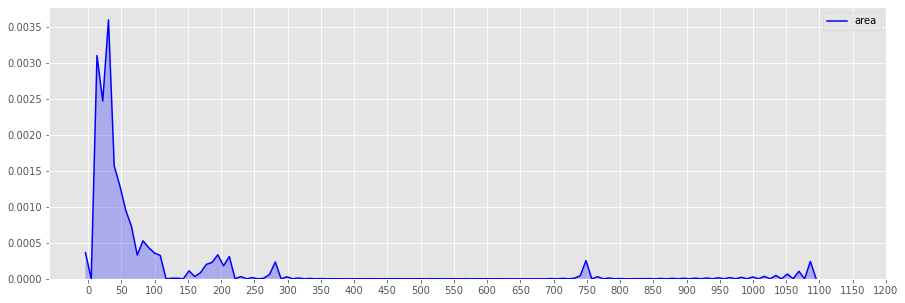

In [ ]:
plt.figure(figsize=(15,5))
ax = sns.kdeplot(data_df[target],shade=True,color='b')
plt.xticks([i for i in range(0,1250,50)])
plt.show()

#### target i.e area is right skewed.

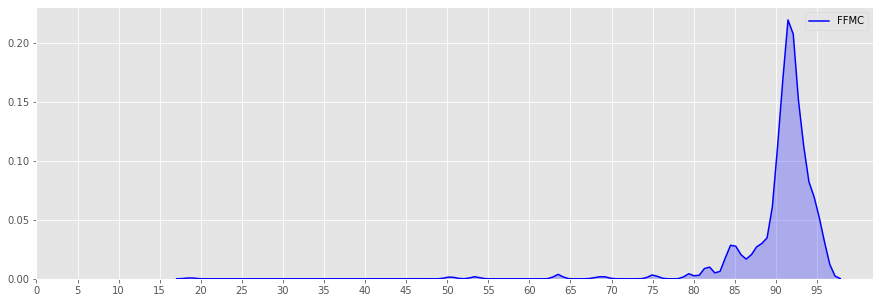

In [ ]:
plt.figure(figsize=(15,5))
ax = sns.kdeplot(data_df['FFMC'],shade=True,color='b')
plt.xticks([i for i in range(0,100,5)])
plt.show()

#### FFMC is left skewed.

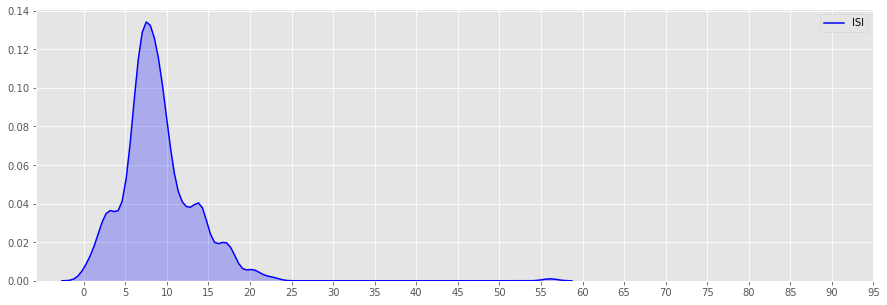

In [ ]:
plt.figure(figsize=(15,5))
ax = sns.kdeplot(data_df['ISI'],shade=True,color='b')
plt.xticks([i for i in range(0,100,5)])
plt.show()

#### ISI is right skewed.

### Outliers

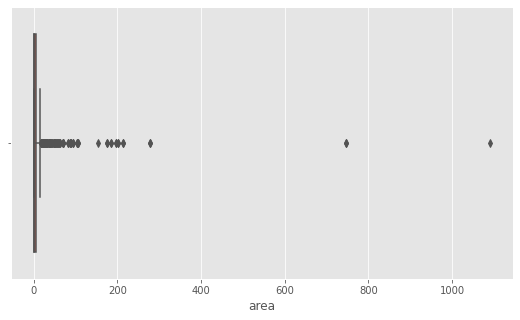

In [ ]:
outl_dect = sns.boxplot(data_df[target])

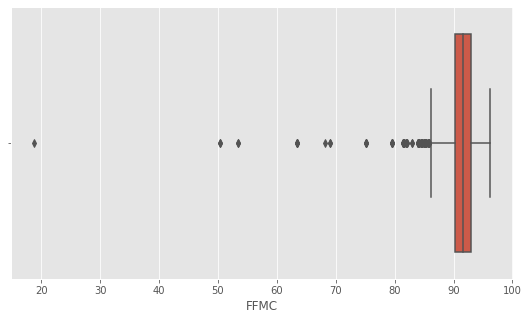

In [ ]:
outl_dect = sns.boxplot(data_df['FFMC'])

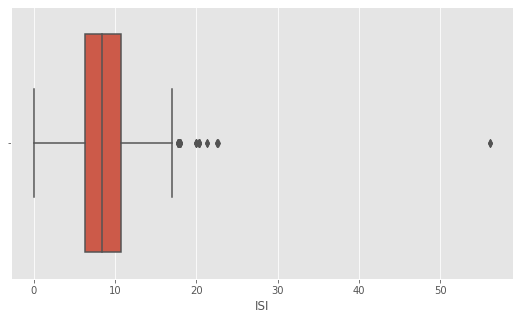

In [ ]:
outl_dect = sns.boxplot(data_df['ISI'])

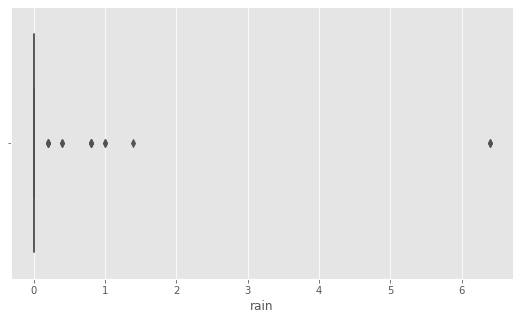

In [ ]:
outl_dect = sns.boxplot(data_df['rain'])

### Outlier analysis

Outliers are found in the following columns:
<ol>
<li>area</li>
<li>FFMC</li>
<li>ISI</li>
<li>rain</li>
</ol>


<p>Instead of removing them we will transform the data to treat the outliers.</p>

In [ ]:
outlier_columns = ['area','FFMC','ISI','rain']

In [ ]:
np.log1p(data_df[outlier_columns]).skew()

area     1.1714
FFMC   -10.7956
ISI     -0.8810
rain    13.9087
dtype: float64

In [ ]:
np.log1p(data_df[outlier_columns]).kurtosis()

area     0.7267
FFMC   179.6091
ISI      2.4126
rain   222.8849
dtype: float64

Even after transformation we still have high skewness and kurtosis in `FFMC` & `rain`

<p>Removing outliers by zscore method.</p>

In [ ]:
mask = data_df.loc[:,['FFMC']].apply(zscore).abs() < 3

In [ ]:
data_df = data_df[mask.values]
data_df.shape

(872, 13)

In [ ]:
data_df['month']

0      mar
1      oct
2      oct
3      mar
4      mar
      ... 
879    aug
880    jul
881    mar
882    apr
883    aug
Name: month, Length: 872, dtype: object

In [ ]:
# Since most of the values in rain are 0.0, we can convert it as a categorical column
data_df['rain'] = data_df['rain'].apply(lambda x: int(x > 0.0))


In [ ]:
outlier_columns.remove('rain')
data_df[outlier_columns] = np.log1p(data_df[outlier_columns])

In [ ]:
data_df[outlier_columns].skew()

area    1.1631
FFMC   -1.8023
ISI    -0.4112
dtype: float64

In [ ]:
data_df[outlier_columns].kurtosis() 

area   0.7074
FFMC   4.8490
ISI    1.1690
dtype: float64

In [ ]:
data_df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,872.0000,872.0000,872.0000,872.0000,872.0000,872.0000,872.0000,872.0000,872.0000,872.0000,872.0000
mean,4.7133,4.3039,4.5221,110.9876,544.9618,2.2216,18.9289,44.0665,4.0096,0.0172,1.1443
std,2.3486,1.2378,0.0355,64.3497,248.9317,0.4311,5.7940,16.0914,1.7783,0.1301,1.4177
min,1.0000,2.0000,4.3320,3.0000,7.9000,0.7419,2.2000,15.0000,0.4000,0.0000,0.0000
25%,3.0000,4.0000,4.5139,61.1000,431.4000,2.0149,15.6000,33.0000,2.7000,0.0000,0.0000
50%,4.0000,4.0000,4.5283,108.3000,661.5500,2.2407,19.3000,41.0000,4.0000,0.0000,0.5188
75%,7.0000,5.0000,4.5422,142.4000,713.9000,2.4596,22.8250,53.0000,4.9000,0.0000,2.0630
max,9.0000,9.0000,4.5768,291.3000,860.6000,4.0448,33.3000,99.0000,9.4000,1.0000,6.9956


Dataset is ready for model preparation.

In [ ]:
data_sel = data_df.copy()

## Applying xgboost

Encoding `day` & `month` column with label encoder

In [ ]:
le = LabelEncoder() 
  
data_sel['day']= le.fit_transform(data_sel['day']) 
data_sel['month']= le.fit_transform(data_sel['month']) 
  
df2['day']= le.fit_transform(df2['day']) 
df2['month']= le.fit_transform(df2['month']) 

In [ ]:
X, y = data_sel.iloc[:,:-1],data_sel.iloc[:,-1]

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [ ]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [ ]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [ ]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [ ]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [ ]:
train = X
y_train = y 

In [ ]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 1.4754 (0.1690)



In [ ]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 1.4754 (0.1690)



In [ ]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 1.4443 (0.1359)



In [ ]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.8606 (0.3014)



In [ ]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Xgboost score: 0.7765 (0.2949)



In [ ]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 1.2658 (0.1620)



In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [ ]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 1.2326 (0.1818)



In [ ]:
KRR.fit(X,y)
ans = KRR.predict(df2)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout
from keras.utils import np_utils
from keras.constraints import maxnorm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    
    # compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=20, batch_size=5, verbose=1)

kfold = KFold(n_splits=30, random_state=seed,shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/1
30/30 [==============================] - 3s 101ms/step
Epoch 1/1
30/30 [==============================] - 3s 102ms/step
Epoch 1/1
29/29 [==============================] - 3s 107ms/step
Epoch 1/1
29/29 [==============================] - 3s 107ms/step
Epoch 1/1
29/29 [==============================] - 3s 108ms/step
Epoch 1/1
29/29 [==============================] - 3s 110ms/step
Epoch 1/1
29/29 [==============================] - 3s 113ms/step
Epoch 1/1
29/29 [==============================] - 3s 112ms/step
Epoch 1/1
29/29 [==============================] - 3s 113ms/step
Epoch 1/1
29/29 [==============================] - 3s 113ms/step
Epoch 1/1
29/29 [==============================] - 3s 114ms/step
Epoch 1/1
29/29 [==============================] - 3s 115ms/step
Epoch 1/1
29/29 [==============================] - 3s 116ms/step
Epoch 1/1
29/29 [==============================] - 3s 118ms/step
Epoch 1/1
29/29 [==============================] - 3s 116ms/step
Epoch 1/1
29/29 [========

In [ ]:
def network_architecture():
    model = Sequential()
    model.add(Dense(640, input_dim=X.shape[1]))
    model.add(Activation('tanh'))
    model.add(Dense(320))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
def keras_model():
    estimators = [
        ('scaler', StandardScaler()),
        ('mlp', KerasRegressor(build_fn=network_architecture, epochs=20))
    ]
    model = Pipeline(estimators)
    model.fit(X,y)
    return model

In [ ]:
model = keras_model()
kfold = KFold(n_splits=30, random_state=seed,shuffle=True)
results = cross_val_score(model, X, y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/20
872/872 [==============================] - 10s 11ms/step - loss: 3.0763
Epoch 2/20
872/872 [==============================] - 0s 443us/step - loss: 2.1807
Epoch 3/20
872/872 [==============================] - 0s 426us/step - loss: 2.0615
Epoch 4/20
872/872 [==============================] - 0s 413us/step - loss: 2.1564
Epoch 5/20
872/872 [==============================] - 0s 421us/step - loss: 2.1824
Epoch 6/20
872/872 [==============================] - 0s 390us/step - loss: 2.1077
Epoch 7/20
872/872 [==============================] - 0s 382us/step - loss: 2.0768
Epoch 8/20
872/872 [==============================] - 0s 421us/step - loss: 1.9591
Epoch 9/20
872/872 [==============================] - 0s 415us/step - loss: 1.9800
Epoch 10/20
872/872 [==============================] - 0s 418us/step - loss: 1.9488
Epoch 11/20
872/872 [==============================] - 0s 415us/step - loss: 1.9411
Epoch 12/20
872/872 [==============================] - 0s 404us/step - loss: 1.9200
E

Dividing dataset into 33% test sample and 67% training sample .

#### verbose set to False so that we can hide results of model fit progress

**Calculate In-Sample and Out-of-Sample R^2 and Error**

**Clearly test error(OSE) is near to the training error(ISE). i.e our model is ok.
**

In [ ]:
estimator.fit(X,y)
ans = estimator.predict(df2)
# this is NN
#ans = pipeline.predict(df2)
#this is pipeline
#ans = grid.best_estimator_.predict(df2)


Epoch 1/1
150/150 [==============================] - 5s 34ms/step


In [ ]:
ids = [i for i in np.arange(367,517)]
results_df = pd.DataFrame(data={'fire_id':ids, 'area':ans})
results_df.to_csv('fire-03.csv', index=False)

In [ ]:
results_df

,fire_id,area
0,367,1.2549
1,368,1.3044
2,369,1.6397
3,370,1.4367
4,371,1.5367
...,...,...
145,512,1.3239
146,513,1.3148
147,514,1.1624
148,515,1.3085
